In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from hyperopt import fmin, tpe, hp
import warnings

Feature Extraction: 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]
C:\Users\ankus\anaconda3\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['temp__mean_abs_change' 'temp__mean_change'
 'temp__mean_second_derivative_central' ...
 'humidity__permutation_entropy__dimension_7__tau_1'
 'humidity__query_similarity_count__query_None__threshold_0.0'
 'humidity__mean_n_absolute_max__number_of_maxima_7'] did not have any finite values. Filling with zeros.
  warnings.warn(
C:\Users\ankus\anaconda3\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['temp__mean_abs_change' 'temp__mean_change'
 'temp__mean_second_derivative_central' ...
 'humidity__permutation_entropy__dimension_7__tau_1'
 'humidity__query_similarity_count__query_None__threshold_0.0'
 'humidity__mean_n_absolute_max__number_of_maxima_7'] did not have any finite values. Filling with zeros.
  warnings.warn(


Model: "sequential_24"                               

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 lstm_48 (LSTM)              (None, 60, 100)           48400     

 lstm_49 (LSTM)              (None, 100)               80400     

 dense_48 (Dense)            (None, 25)                2525      

 dense_49 (Dense)            (None, 1)                 26        


Total params: 131351 (513.09 KB)                     

Trainable params: 131351 (513.09 KB)                 

Non-trainable params: 0 (0.00 Byte)                  

_________________________________________________________________

30/30 [==============================] - 2s 34ms/step

Model: "sequential_25"                                                           

_________________________________________________________________                

 Layer (type)                Output Shape              Param #                   


 lst

30/30 [==============================] - 2s 33ms/step                           

Model: "sequential_28"                                                           

_________________________________________________________________                

 Layer (type)                Output Shape              Param #                   


 lstm_56 (LSTM)              (None, 60, 100)           48400                     

 lstm_57 (LSTM)              (None, 100)               80400                     

 dense_56 (Dense)            (None, 25)                2525                      

 dense_57 (Dense)            (None, 1)                 26                        


Total params: 131351 (513.09 KB)                                                 

Trainable params: 131351 (513.09 KB)                                             

Non-trainable params: 0 (0.00 Byte)                                              

_________________________________________________________________                

30/

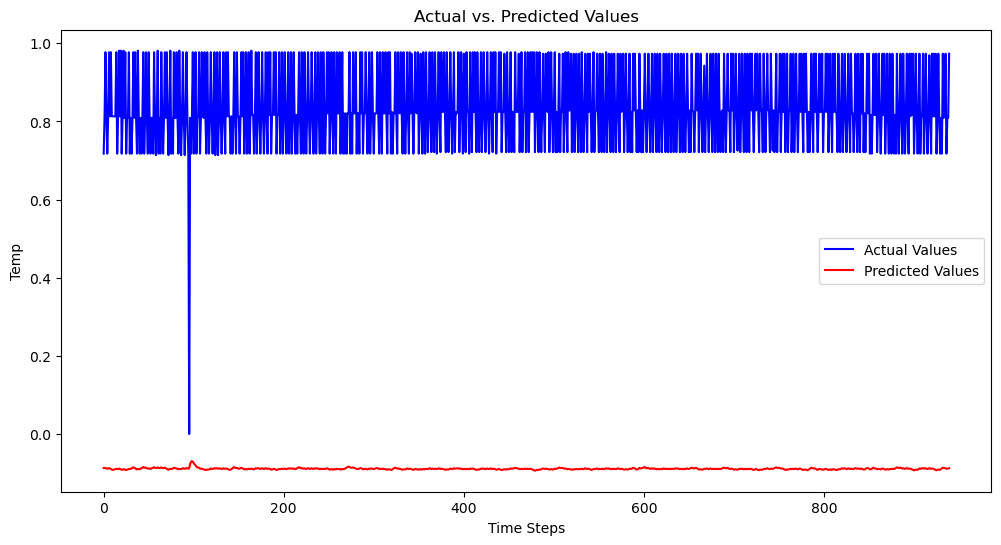

In [7]:
warnings.filterwarnings("ignore", category=UserWarning, module="tsfresh")
# Load sensor data
def upload_sensor_data():
    sensor_data = pd.read_csv('C:/Users/ankus/sensor.csv')
    sensor_data = sensor_data[:5000]
    sensor_data = sensor_data.drop(['motion'], axis=1)  # It only has false values
    label_encoder = LabelEncoder()
    sensor_data['device'] = label_encoder.fit_transform(sensor_data['device'])
    sensor_data['light'] = label_encoder.fit_transform(sensor_data['light'])
    sensor_data['time'] = pd.to_datetime(sensor_data['ts'], unit="s")
    sensor_data = sensor_data.drop(['lpg', 'smoke', 'co', 'ts'], axis=1)  # Dropping these columns because of high correlation
    return sensor_data

# Prepare data for time series prediction
def prepare_data(sensor_data, target_column='temp', n_steps=60):
    numerical_columns = sensor_data[['temp', 'humidity']]  # Include 'humidity' as a feature
    numerical_columns = numerical_columns.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(numerical_columns)
    scaled_df = pd.DataFrame(scaled_data, columns=['temp', 'humidity'])
    scaled_df['time'] = pd.Series(sensor_data.index)


    train_size = int(len(sensor_data) * 0.8)
    train_data = scaled_df.iloc[:train_size]
    test_data = scaled_df.iloc[train_size:]

    X_train_features, X_test_features, y_train, y_test = extract_and_prepare_features(
        train_data, test_data, target_column)

    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = reshape_for_lstm(
        X_train_features, X_test_features, y_train, y_test, n_steps)

    return X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm

def select_top_features(X, y, num_features):
    """Manually select the top features based on feature importance."""
    rf = RandomForestRegressor()
    rf.fit(X, y)
    
    importances = rf.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    
    top_indices = sorted_indices[:num_features]
    return top_indices

# Extract and prepare features
def extract_and_prepare_features(train_data, test_data, target_column):
    X_train_features = extract_features(train_data, column_id='time')
    X_test_features = extract_features(test_data, column_id='time')

    X_train_features = impute(X_train_features)
    X_test_features = impute(X_test_features)

    y_train = train_data[target_column][X_train_features.index]
    y_test = test_data[target_column][X_test_features.index]

    top_feature_indices = select_top_features(X_train_features, y_train, num_features=20)
    X_train_selected = X_train_features.iloc[:, top_feature_indices]
    X_test_selected = X_test_features.iloc[:, top_feature_indices]

    X_train_selected.index = train_data.index
    X_test_selected.index = test_data.index

    return X_train_selected, X_test_selected, y_train, y_test

# Reshape data for LSTM input
def reshape_for_lstm(X_train_selected, X_test_selected, y_train, y_test, n_steps):
    X_train_lstm, X_test_lstm = [], []
    y_train_lstm, y_test_lstm = [], []

    for i in range(len(X_train_selected) - n_steps):
        X_train_lstm.append(X_train_selected[i:i + n_steps])
        y_train_lstm.append(y_train.iloc[i + n_steps])

    for i in range(len(X_test_selected) - n_steps):
        X_test_lstm.append(X_test_selected[i:i + n_steps])
        y_test_lstm.append(y_test.iloc[i + n_steps])

    return (
        np.array(X_train_lstm), np.array(X_test_lstm),
        np.array(y_train_lstm), np.array(y_test_lstm)
    )

# Build an LSTM model
def build_lstm_model(input_shape):
    model = keras.Sequential()
    model.add(layers.LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(layers.LSTM(100, return_sequences=False))
    model.add(layers.Dense(25))
    model.add(layers.Dense(1))
    model.summary()
    return model

def objective(params):
    """
    Define the objective function to be minimized during hyperparameter tuning.
    This function returns the negative RMSE, as Hyperopt aims to minimize the objective.
    """
    model = build_lstm_model(input_shape)
    model.compile(optimizer=params['optimizer'], loss='mean_squared_error')
    
    model.fit(X_train_lstm, y_train_lstm, batch_size=params['batch_size'], epochs=params['epochs'], verbose=0)
    predictions = model.predict(X_test_lstm)
    rmse = np.sqrt(np.mean((predictions - y_test_lstm) ** 2))
    return -rmse  # Negative RMSE since Hyperopt minimizes the objective

# Main function
def main():
    target_column = 'temp'
    n_steps = 60

    # Download sensor data
    sensor_data = upload_sensor_data()

    # Prepare data for time series prediction
    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = prepare_data(
        sensor_data, target_column, n_steps)

    # Build the LSTM model
    input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

    # Define the hyperparameter search space
    space = {
        'optimizer': hp.choice('optimizer', ['adam', 'sgd', 'rmsprop']),
        'batch_size': hp.choice('batch_size', [16, 32]),
        'epochs': hp.choice('epochs', [10, 20])
    }

    def objective(params):
        model = build_lstm_model(input_shape)
        optimizer = params['optimizer']
        if optimizer == 'adam':
            opt = keras.optimizers.Adam()
        elif optimizer == 'sgd':
            opt = keras.optimizers.SGD()
        else:
            opt = keras.optimizers.RMSprop()

        model.compile(optimizer=opt, loss='mean_squared_error')

        model.fit(X_train_lstm, y_train_lstm, batch_size=params['batch_size'], epochs=params['epochs'], verbose=0)
        predictions = model.predict(X_test_lstm)
        rmse = np.sqrt(np.mean((predictions - y_test_lstm) ** 2))
        return rmse

    # Perform hyperparameter tuning
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=5)

    # Build the LSTM model with best hyperparameters
    best_model = build_lstm_model(input_shape)
    optimizer = best['optimizer']
    if optimizer == 0:
        opt = keras.optimizers.Adam()
    elif optimizer == 1:
        opt = keras.optimizers.SGD()
    else:
        opt = keras.optimizers.RMSprop()

    best_model.compile(optimizer=opt, loss='mean_squared_error')

    # Fit the best model to the training data
    best_model.fit(X_train_lstm, y_train_lstm, batch_size=best['batch_size'], epochs=best['epochs'], verbose=2)

    # Make predictions using the best model
    predictions = best_model.predict(X_test_lstm)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((predictions - y_test_lstm) ** 2))

    print("Best hyperparameters:", best)
    print(f"Optimizer: {best['optimizer']}")
    print(f"Batch Size: {best['batch_size']}")
    print(f"Epochs: {best['epochs']}")
    print(f"Root Mean Square Error (RMSE): {rmse}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_lstm, label="Actual Values", color="blue")
    plt.plot(predictions, label="Predicted Values", color="red")
    plt.title("Actual vs. Predicted Values")
    plt.xlabel("Time Steps")
    plt.ylabel("Temp")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
